<a href="https://colab.research.google.com/github/MadelayneLoor/ABSA/blob/main/AbsaMade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ABSA basado en textos de retroalimentacione educativas

## Importacion de los paquetes necesarios

In [ ]:
#pip install numpy
#pip install pandas
#pip install matplotlib

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
# Importacion de los paquetes necesarios
data = pd.read_csv('/content/datasetABSA.csv')
# Head del dataframe
data.head()

,Comentario,Aspecto,Polaridad
0,la caratula sin errores ortograficos,caratula,2
1,la estructura del documento se visualiza corre...,estructura,1
2,no existen herencias la relacion entre los cas...,herencias,0
3,al existir tantos errores en el procedimientos...,errores,0
4,la caratula sin errores ortograficos,caratula,2


In [ ]:
data.shape

(4253, 3)

In [ ]:
summary = data.describe(include='all')
summary

,Comentario,Aspecto,Polaridad
count,4253,4253,4253.000000
unique,3564,218,NaN
top,el flujo base y flujo alterno de las actividad...,nombre,NaN
freq,23,283,NaN
mean,NaN,NaN,0.962850
std,NaN,NaN,0.853598
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,1.000000
75%,NaN,NaN,2.000000


In [ ]:
longest_sentence_length = data['Comentario'].apply(len).max()
longest_sentence_length

765

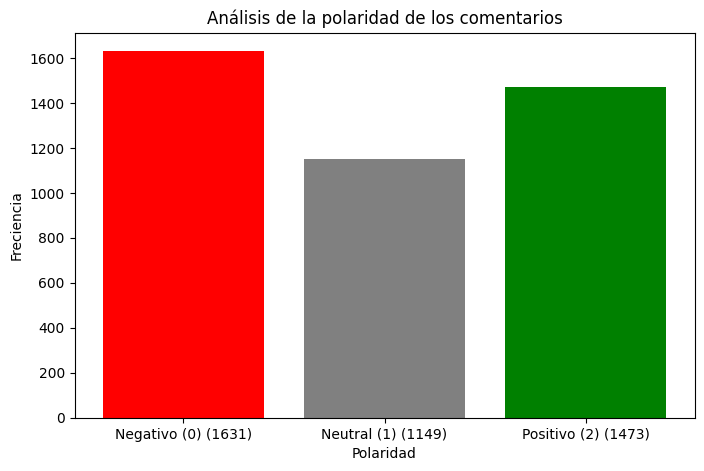

In [ ]:
labels = ['Negativo (0)', 'Neutral (1)', 'Positivo (2)']
polarity_counts = data['Polaridad'].value_counts().sort_index()
polarity_counts_sorted = polarity_counts.sort_index()
adjusted_labels = [f'{label} ({count})' for label, count in zip(labels[:len(polarity_counts_sorted)], polarity_counts_sorted)]

plt.figure(figsize=(8, 5))
plt.bar(adjusted_labels, polarity_counts_sorted, color=['red', 'gray', 'green'] [:len(polarity_counts_sorted)])

plt.title('Análisis de la polaridad de los comentarios')
plt.xlabel('Polaridad')
plt.ylabel('Freciencia')
plt.show()


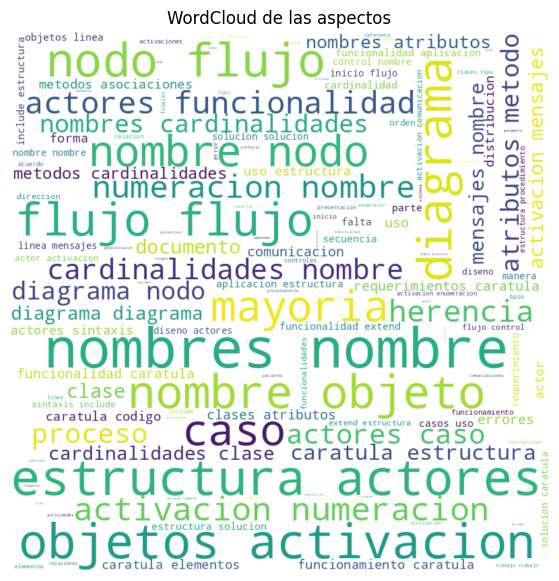

In [ ]:
aspectt_text = " ".join(data['Aspecto'])
wordcloud = WordCloud(width=800, height=800, background_color="white").generate(aspectt_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud de las aspectos")
plt.show()


## Porcesamiento de data

In [ ]:
data['Comentario'] = data.apply(lambda row: f"[CLS] {row['Comentario']} [SEP] {row['Aspecto']} [SEP]", axis=1)

In [ ]:
data.head()

,Comentario,Aspecto,Polaridad
0,[CLS] la caratula sin errores ortograficos [SE...,caratula,2
1,[CLS] la estructura del documento se visualiza...,estructura,1
2,[CLS] no existen herencias la relacion entre l...,herencias,0
3,[CLS] al existir tantos errores en el procedim...,errores,0
4,[CLS] la caratula sin errores ortograficos [SE...,caratula,2


In [ ]:
from sklearn.model_selection import train_test_split

train_data, temp_data = train_test_split(
    data,
    test_size=0.3,
    random_state=42,
    stratify=data['Polaridad']
)

val_data, test_data = train_test_split(
    temp_data,
    test_size=0.5,
    random_state=42,
    stratify=temp_data['Polaridad']
)

print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Train samples: {len(train_data)}")


Validation samples: 638
Test samples: 638
Train samples: 2977


## Entrenamiendo del modelo

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class SentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence = row["Comentario"]
        label = row["Polaridad"]

        encoding = self.tokenizer(
            sentence,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

In [ ]:
# Tokkenizador ve dataset

from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
max_len = 128

train_dataset = SentimentDataset(train_data, tokenizer, max_len)
val_dataset = SentimentDataset(val_data, tokenizer, max_len)
test_dataset = SentimentDataset(test_data, tokenizer, max_len)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from transformers import BertForSequenceClassification, get_scheduler

#Modelo

model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased',  num_labels=3)

model.to(device)

#optimizar an scheduler

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.005)
num_training_steps = len(train_dataloader) * 3  # 3 epoch
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps,
)


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from tqdm import tqdm

def train_one_epoch(model, data_loader, optimizer, device, scheduler=None):
    model.train()
    total_loss = 0

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

    avg_loss = total_loss / len(data_loader)
    return avg_loss

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    return avg_loss

## Entrenamiendo del modelocon 5 epocas

In [ ]:
import matplotlib.pyplot as plt

# Listas para almacenar las pérdidas
train_losses = []
val_losses = []

epochs = 7
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss = train_one_epoch(model, train_dataloader, optimizer, device, lr_scheduler)
    val_loss = evaluate(model, val_dataloader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/7


Evaluation: 100%|██████████| 80/80 [00:04<00:00, 17.55it/s]


Training Loss: 0.3995, Validation Loss: 0.1541
Epoch 2/7


Evaluation: 100%|██████████| 80/80 [00:04<00:00, 16.18it/s]


Training Loss: 0.1274, Validation Loss: 0.1611
Epoch 3/7


Evaluation: 100%|██████████| 80/80 [00:04<00:00, 16.76it/s]


Training Loss: 0.0648, Validation Loss: 0.1447
Epoch 4/7


Evaluation: 100%|██████████| 80/80 [00:04<00:00, 17.13it/s]


Training Loss: 0.0428, Validation Loss: 0.1447
Epoch 5/7


Evaluation: 100%|██████████| 80/80 [00:04<00:00, 17.15it/s]


Training Loss: 0.0445, Validation Loss: 0.1447
Epoch 6/7


Evaluation: 100%|██████████| 80/80 [00:04<00:00, 17.06it/s]


Training Loss: 0.0459, Validation Loss: 0.1447
Epoch 7/7


Evaluation: 100%|██████████| 80/80 [00:04<00:00, 17.02it/s]

Training Loss: 0.0432, Validation Loss: 0.1447


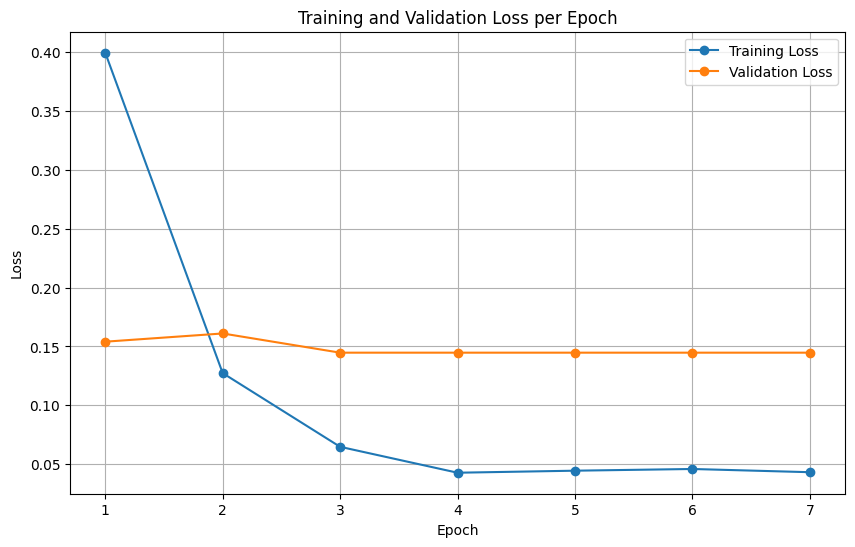

In [ ]:
# Graficar las pérdidas
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, epochs + 1))  # Etiquetas de las épocas en el eje X
plt.legend()
plt.grid(True)
plt.show()


## Guardar el modelo

In [ ]:
save_directory = "ABSA_model_v1"

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Modelo Tokenizado '{save_directory}' guardado!!!")

Modelo Tokenizado 'ABSA_model_v1' guardado!!!


## Porceso de prueba

In [ ]:
from sklearn.metrics import classification_report
def test_model(model, data_loader, device, class_names):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():

        for batch in data_loader:

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average="weighted")

    # Generar informe detallado por clase
    report = classification_report(true_labels, predictions, target_names=class_names, zero_division=0)

    return accuracy, f1, report

# Lista de nombres de las clases en el mismo orden que las etiquetas
class_names = ["Negativo", "Neutral", "Positivo"]

test_accuracy, test_f1 , test_report = test_model(model, test_dataloader, device, class_names)
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")
print("\nDetailed Classification Report:")
print(test_report)


Test Accuracy: 0.9624, Test F1 Score: 0.9626

Detailed Classification Report:
              precision    recall  f1-score   support

    Negativo       0.97      0.95      0.96       245
     Neutral       0.91      0.95      0.93       172
    Positivo       0.99      0.98      0.99       221

    accuracy                           0.96       638
   macro avg       0.96      0.96      0.96       638
weighted avg       0.96      0.96      0.96       638



## Pueba del modelo

In [ ]:
def predict_aspect_sentiment(model, tokenizer, text, aspect, device, max_len=128):


    formatted_text = f"[CLS] {text} [SEP] {aspect} [SEP]"

    encoding = tokenizer(
        formatted_text,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    label_mapping_reverse = {0: "Negativo", 1: "Neutral", 2: "Positivo"}
    sentiment = label_mapping_reverse[predicted_class]

    return sentiment


In [ ]:
text = "Se declara que al no tener en uso un proceso de gestión, optar por el uso de uno, de una forma bastante detallada "
aspect = "proceso"

predicted_sentiment = predict_aspect_sentiment(
    model, tokenizer, text, aspect, device
)

print(f"Aspect: {predicted_sentiment}")

Aspect: Negativo
